In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib

In [2]:
dfs = pd.read_csv('MoodyLyrics-1865-Sentiment-Audio.csv', encoding="utf-8")
dfs.head(5)

,index,artist,title,lyrics sentiment,mood,lyrics,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,ML1,George Michael,I Want Your Sex,pos,happy,In the past there were arguments for and again...,6QnFHieoch6U9J8zfv6hml,0.812,0.600,10,-13.418,0,0.0538,0.005090,0.02480,0.0465,0.800,99.189
1,ML2,Rob Zombie,Pussy Liquor,neg,angry,Baby :\nGimme a B\nGimme a A\nGimme a B\nGimme...,03VzAAMs5PrLM42XR7ijuc,0.540,0.923,10,-3.965,1,0.0324,0.000347,0.00614,0.4840,0.531,112.936
2,ML3,Katatonia,12,neg,sad,Black theatre of love\nViolet dancers cast the...,4GCOPgFknQSHVXuAAdQYjk,0.134,0.674,6,-8.428,1,0.0478,0.000460,0.70300,0.2040,0.162,69.289
3,ML4,Bing Crosby,Swinging On A Star,pos,happy,Would you like to swing on a star\nCarry moonb...,7xy0PAZxzGDOcYzyptvprd,0.706,0.167,0,-13.137,1,0.0602,0.896000,0.00000,0.1010,0.724,139.763
4,ML5,Ludacris,Get Back,neg,angry,"Heads up! (woop, woop) Heads up! (woop, woop)\...",6o3MvjWfF0jczTzPRcfZsK,0.562,0.638,1,-5.141,1,0.2750,0.055900,0.00000,0.1270,0.165,171.758


In [3]:
targetLabels = np.asarray(dfs['mood'], dtype="str")

In [4]:
mode_dict = {0: "minor", 1: "major"}

In [5]:
def cal_hm_acc(class_report):
    labels = dfs['mood'].value_counts().index.tolist()
    sum_recall = 0
    for x in labels: 
        sum_recall += 1/class_report[x]['recall']
    harmonic_mean_acc = 1/((1/len(labels))*(sum_recall))
    return harmonic_mean_acc

### Categorical Features

In [6]:
cat_features =  ['lyrics sentiment', 'mode']

dfs = dfs.replace({"mode": mode_dict})

cat_dfs = dfs[cat_features]

cat_dfs.head(5)


,lyrics sentiment,mode
0,pos,minor
1,neg,major
2,neg,major
3,pos,major
4,neg,major


### Continuous Features

In [7]:
cont_features = ['danceability', 'energy', 'loudness', 'valence', 'tempo']

cont_dfs = dfs[cont_features]

#cont_dfs['tempo'] = cont_dfs['tempo'].apply(np.floor)

cont_dfs.head(5)


,danceability,energy,loudness,valence,tempo
0,0.812,0.600,-13.418,0.800,99.189
1,0.540,0.923,-3.965,0.531,112.936
2,0.134,0.674,-8.428,0.162,69.289
3,0.706,0.167,-13.137,0.724,139.763
4,0.562,0.638,-5.141,0.165,171.758


In [8]:
data = np.hstack((cat_dfs, cont_dfs))

In [9]:
data[0:5]

array([['pos', 'minor', 0.812, 0.6, -13.418, 0.8, 99.189],
       ['neg', 'major', 0.54, 0.923, -3.965, 0.531, 112.936],
       ['neg', 'major', 0.134, 0.674, -8.427999999999999, 0.162, 69.289],
       ['pos', 'major', 0.706, 0.16699999999999998, -13.137,
        0.7240000000000001, 139.763],
       ['neg', 'major', 0.562, 0.638, -5.141, 0.165, 171.75799999999995]],
      dtype=object)

In [10]:
instances_train, instances_test, target_train, target_test = train_test_split(data, targetLabels, test_size=0.2, random_state=0)

In [11]:
instances_train[0:5]

array([['pos', 'major', 0.522, 0.889, -5.2620000000000005, 0.924,
        123.736],
       ['neg', 'minor', 0.545, 0.154, -19.318, 0.152, 121.485],
       ['pos', 'major', 0.6579999999999999, 0.317, -11.705, 0.486,
        128.87],
       ['neg', 'minor', 0.568, 0.906, -3.773, 0.368, 119.884],
       ['neg', 'major', 0.64, 0.153, -22.873, 0.34, 97.689]], dtype=object)

In [12]:
target_train[0:5]

array(['happy', 'sad', 'relaxed', 'sad', 'relaxed'], dtype='<U7')

In [13]:
headers = cat_features+cont_features

### Training data

In [14]:
train_df = pd.DataFrame(data=instances_train[0:,0:], columns=headers)

### Testing data

In [15]:
test_df = pd.DataFrame(data=instances_test[0:,0:], columns=headers)

In [16]:
train_df

,lyrics sentiment,mode,danceability,energy,loudness,valence,tempo
0,pos,major,0.522,0.889,-5.262,0.924,123.736
1,neg,minor,0.545,0.154,-19.318,0.152,121.485
2,pos,major,0.658,0.317,-11.705,0.486,128.87
3,neg,minor,0.568,0.906,-3.773,0.368,119.884
4,neg,major,0.64,0.153,-22.873,0.34,97.689
...,...,...,...,...,...,...,...
1487,neg,major,0.457,0.779,-6.323,0.734,86.573
1488,neg,minor,0.684,0.677,-9.201,0.774,114.992
1489,pos,major,0.593,0.542,-10.155,0.564,130.219
1490,neg,major,0.221,0.967,-6.717,0.0395,107.56


In [17]:
test_df

,lyrics sentiment,mode,danceability,energy,loudness,valence,tempo
0,neg,major,0.543,0.579,-9.262,0.159,119.56
1,pos,major,0.487,0.933,-3.321,0.769,169.929
2,neg,major,0.48,0.835,-4.94,0.0649,162.014
3,pos,major,0.664,0.889,-3.058,0.729,124.986
4,neg,major,0.504,0.921,-5.698,0.684,175.503
...,...,...,...,...,...,...,...
368,pos,major,0.669,0.493,-11.398,0.556,131.076
369,neg,minor,0.39,0.772,-7.257,0.0876,168.044
370,neg,major,0.247,0.997,-3.992,0.039,183.647
371,neg,minor,0.804,0.73,-4.622,0.169,84.899


## Prepare data for Naive Bayes Classifier

For naive bayes classification, the continuous features were converted to categorical features using equal frequency binning

In [18]:
train_df = pd.DataFrame(data=instances_train[0:,0:], columns=headers)

In [19]:
test_df = pd.DataFrame(data=instances_test[0:,0:], columns=headers)

In [20]:
def equal_freq_bin(bin_df):
    freq = 4 # 1472
    bin_intervals = dict.fromkeys(cont_features, 0)
    for feature in cont_features:
        bin_df[feature+" binned"] = pd.qcut(bin_df[feature], q=freq).astype("str")
        intervals = pd.qcut(bin_df[feature], q=freq).value_counts(sort=False)
        intv_list = intervals.index.to_list()
        intv_list.insert(0, "<= minimum")
        intv_list.append("> maximum")
        bin_intervals[feature] = intv_list
        
    return bin_intervals

binning_thresh = equal_freq_bin(train_df)
train_df.head(3)

,lyrics sentiment,mode,danceability,energy,loudness,valence,tempo,danceability binned,energy binned,loudness binned,valence binned,tempo binned
0,pos,major,0.522,0.889,-5.262,0.924,123.736,"(0.506, 0.628]","(0.879, 0.999]","(-5.296, -0.938]","(0.664, 0.982]","(119.737, 140.05]"
1,neg,minor,0.545,0.154,-19.318,0.152,121.485,"(0.506, 0.628]","(0.00302, 0.447]","(-34.317, -10.824]","(0.0314, 0.226]","(119.737, 140.05]"
2,pos,major,0.658,0.317,-11.705,0.486,128.87,"(0.628, 0.962]","(0.00302, 0.447]","(-34.317, -10.824]","(0.426, 0.664]","(119.737, 140.05]"


In [34]:
binning_thresh

{'danceability': ['<= minimum',
  Interval(0.0768, 0.384, closed='right'),
  Interval(0.384, 0.506, closed='right'),
  Interval(0.506, 0.628, closed='right'),
  Interval(0.628, 0.962, closed='right'),
  '> maximum'],
 'energy': ['<= minimum',
  Interval(0.00302, 0.447, closed='right'),
  Interval(0.447, 0.696, closed='right'),
  Interval(0.696, 0.879, closed='right'),
  Interval(0.879, 0.999, closed='right'),
  '> maximum'],
 'loudness': ['<= minimum',
  Interval(-34.317, -10.824, closed='right'),
  Interval(-10.824, -7.541, closed='right'),
  Interval(-7.541, -5.296, closed='right'),
  Interval(-5.296, -0.938, closed='right'),
  '> maximum'],
 'valence': ['<= minimum',
  Interval(0.0314, 0.226, closed='right'),
  Interval(0.226, 0.426, closed='right'),
  Interval(0.426, 0.664, closed='right'),
  Interval(0.664, 0.982, closed='right'),
  '> maximum'],
 'tempo': ['<= minimum',
  Interval(36.958000000000006, 99.387, closed='right'),
  Interval(99.387, 119.737, closed='right'),
  Interval

In [40]:
pd.Interval(0,5, closed='right')

Interval(0, 5, closed='right')

In [21]:
def apply_eqf_bins(feature, x):
    intervals = binning_thresh[feature]
    binned_feature = []
    for val in x:
        if val <= intervals[1].left:# Check if less than or equal to minimum
            binned_feature.append(intervals[0])
        elif val > intervals[4].right: # Check if more than maximum
            binned_feature.append(intervals[5])
        elif val <= intervals[1].right: # Check if less than or equal to lowest bin value
            binned_feature.append(str(intervals[1]))
        elif val <= intervals[2].right:
            binned_feature.append(str(intervals[2]))
        elif val <= intervals[3].right:
            binned_feature.append(str(intervals[3]))
        elif val <= intervals[4].right: # Check if less than or equal to highest bin value
            binned_feature.append(str(intervals[4]))
    
    return binned_feature
                    
#tester = [0.001, 250, 217]
#ret = apply_eqf_bins('tempo', tester)
#ret

for col in test_df.columns[2:7]:
    test_df[col+" binned"] = apply_eqf_bins(col, test_df[col])

In [22]:
test_df['tempo binned'][0]

'(99.387, 119.737]'

In [27]:
bin_cont_features = ['danceability binned', 'energy binned', 'loudness binned', 'valence binned', 'tempo binned']
#continuous = train_df[bin_cont_features]
categorical = train_df[cat_features + bin_cont_features]

# Vectorise features
#continuous = continuous.T.to_dict().values()
categorical = categorical.T.to_dict().values()
vectorizer = DictVectorizer(sparse = False)
#vec_continuous = vectorizer.fit_transform(continuous)
vec_categorical = vectorizer.fit_transform(categorical)

In [28]:
bin_cont_features = ['danceability binned', 'energy binned', 'loudness binned', 'valence binned', 'tempo binned']
#test_continuous = test_df[bin_cont_features]
test_categorical = test_df[cat_features + bin_cont_features]

# Vectorise features
#test_continuous = test_continuous.T.to_dict().values()
test_categorical = test_categorical.T.to_dict().values()
#vectorizer = DictVectorizer(sparse = False)
#test_vec_continuous = vectorizer.transform(test_continuous)
test_vec_categorical = vectorizer.transform(test_categorical)

In [29]:
train_data = vec_categorical

In [30]:
train_data[0]

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1.])

In [31]:
test_data = test_vec_categorical

In [32]:
test_data[0]

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0.])

### Complement Naive Bayes

In [63]:
cnb_model = ComplementNB()
scores = cross_val_score(cnb_model, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.62       0.68       0.65100671 0.59731544 0.65100671 0.59731544
 0.58389262 0.68456376 0.67785235 0.5704698 ]
Accuracy: 0.6313 (+/- 0.08)


Accuracy = 0.646112600536193
Confusion Matrix:


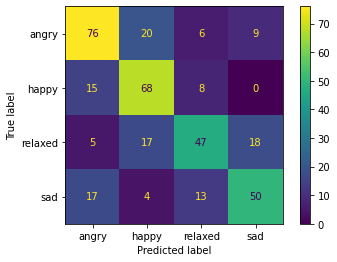

              precision    recall  f1-score   support

       angry       0.67      0.68      0.68       111
       happy       0.62      0.75      0.68        91
     relaxed       0.64      0.54      0.58        87
         sad       0.65      0.60      0.62        84

    accuracy                           0.65       373
   macro avg       0.65      0.64      0.64       373
weighted avg       0.65      0.65      0.64       373



In [64]:
cnb_model.fit(train_data, target_train)
predictions = cnb_model.predict(test_data)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(cnb_model, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [65]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6319289588802857

### Gaussian Naive Bayes

In [117]:
gnb_model = GaussianNB()
scores = cross_val_score(gnb_model, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.64666667 0.68       0.67785235 0.63087248 0.65771812 0.60402685
 0.5704698  0.63758389 0.69798658 0.59060403]
Accuracy: 0.6394 (+/- 0.08)


Accuracy = 0.646112600536193
Confusion Matrix:


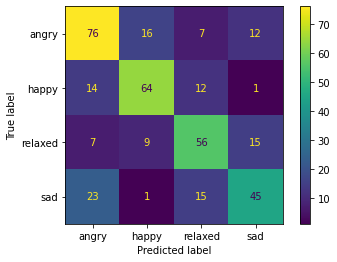

              precision    recall  f1-score   support

       angry       0.63      0.68      0.66       111
       happy       0.71      0.70      0.71        91
     relaxed       0.62      0.64      0.63        87
         sad       0.62      0.54      0.57        84

    accuracy                           0.65       373
   macro avg       0.65      0.64      0.64       373
weighted avg       0.65      0.65      0.65       373



In [41]:
gnb_model.fit(train_data, target_train)
predictions = gnb_model.predict(test_data)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(gnb_model, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [42]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6346547436937772

### Multinomial Naive Bayes

In [118]:
mnb_model = MultinomialNB()
scores = cross_val_score(mnb_model, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.62666667 0.70666667 0.68456376 0.63758389 0.65771812 0.60402685
 0.59060403 0.65100671 0.67785235 0.58389262]
Accuracy: 0.6421 (+/- 0.08)


Accuracy = 0.6568364611260054
Confusion Matrix:


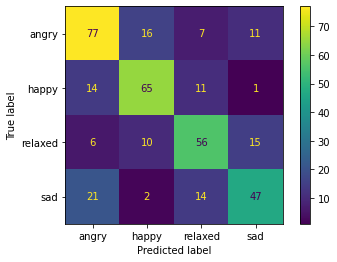

              precision    recall  f1-score   support

       angry       0.65      0.69      0.67       111
       happy       0.70      0.71      0.71        91
     relaxed       0.64      0.64      0.64        87
         sad       0.64      0.56      0.59        84

    accuracy                           0.66       373
   macro avg       0.66      0.65      0.65       373
weighted avg       0.66      0.66      0.66       373



In [119]:
mnb_model.fit(train_data, target_train)
predictions = mnb_model.predict(test_data)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(mnb_model, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [120]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6470017062234136

### Bernoulli Naive Bayes

In [60]:
bnb_model = BernoulliNB()
scores = cross_val_score(bnb_model, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.62       0.68666667 0.66442953 0.61073826 0.66442953 0.62416107
 0.59731544 0.65771812 0.67114094 0.58389262]
Accuracy: 0.6380 (+/- 0.07)


Accuracy = 0.6595174262734584
Confusion Matrix:


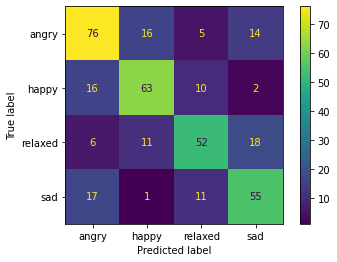

              precision    recall  f1-score   support

       angry       0.66      0.68      0.67       111
       happy       0.69      0.69      0.69        91
     relaxed       0.67      0.60      0.63        87
         sad       0.62      0.65      0.64        84

    accuracy                           0.66       373
   macro avg       0.66      0.66      0.66       373
weighted avg       0.66      0.66      0.66       373



In [61]:
bnb_model.fit(train_data, target_train)
predictions = bnb_model.predict(test_data)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(bnb_model, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [62]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6551662699087837

### Save Model using joblib

In [ ]:
vectorizer = DictVectorizer(sparse = False)
bnb_model = BernoulliNB()
bnb_model.fit(train_data, target_train)

In [51]:
bin_cont_features = ['danceability binned', 'energy binned', 'loudness binned', 'valence binned', 'tempo binned']
categorical = train_df[cat_features + bin_cont_features]

# Vectorise features
pip_data = categorical.T.to_dict().values()

In [47]:
music_clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse = False)),
    ('model', BernoulliNB())
])

music_clf.fit(pip_data, target_train)

Pipeline(steps=[('vectorizer', DictVectorizer(sparse=False)),
                ('model', BernoulliNB())])

In [59]:
scores = cross_val_score(music_clf, pip_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

TypeError: Singleton array array(dict_values([{'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(140.05, 217.396]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.00302, 0.447]', 'loudness binned': '(-34.317, -10.824]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.226, 0.426]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'pos', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.696, 0.879]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(36.958000000000006, 99.387]'}, {'lyrics sentiment': 'neg', 'mode': 'minor', 'danceability binned': '(0.628, 0.962]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.664, 0.982]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'pos', 'mode': 'major', 'danceability binned': '(0.506, 0.628]', 'energy binned': '(0.447, 0.696]', 'loudness binned': '(-10.824, -7.541]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(119.737, 140.05]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.0768, 0.384]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-7.541, -5.296]', 'valence binned': '(0.0314, 0.226]', 'tempo binned': '(99.387, 119.737]'}, {'lyrics sentiment': 'neg', 'mode': 'major', 'danceability binned': '(0.384, 0.506]', 'energy binned': '(0.879, 0.999]', 'loudness binned': '(-5.296, -0.938]', 'valence binned': '(0.426, 0.664]', 'tempo binned': '(36.958000000000006, 99.387]'}]),
      dtype=object) cannot be considered a valid collection.

Accuracy = 0.6595174262734584
Confusion Matrix:


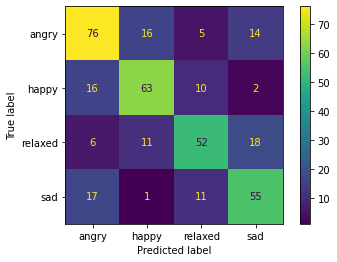

              precision    recall  f1-score   support

       angry       0.66      0.68      0.67       111
       happy       0.69      0.69      0.69        91
     relaxed       0.67      0.60      0.63        87
         sad       0.62      0.65      0.64        84

    accuracy                           0.66       373
   macro avg       0.66      0.66      0.66       373
weighted avg       0.66      0.66      0.66       373



In [57]:
music_clf.predict(test_categorical)
predictions = music_clf.predict(test_categorical)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(music_clf, test_categorical, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [58]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6551662699087837

In [66]:
joblib.dump(bnb_model, "moodify_models\musicmood_bnb.joblib")

['moodify_models\\musicmood_bnb.joblib']

In [61]:
joblib.dump(music_clf, "moodify_models\musicmood_bnb_pipeline.joblib")

['moodify_models\\musicmood_bnb_pipeline.joblib']

In [69]:
musicmood_clf = joblib.load('moodify_models\\musicmood_bnb.joblib')
jbl_predict = musicmood_clf.predict(test_data)

In [62]:
musicmood_clf = joblib.load('moodify_models\\musicmood_bnb_pipeline.joblib')
jbl_predict = musicmood_clf.predict(test_categorical)

In [63]:
print("Accuracy = " + str(accuracy_score(target_test, jbl_predict, normalize=True)))

Accuracy = 0.6595174262734584


## Prepare data for Decision Tree/Random Forest

For decision trees and random forest there is minimal adjustments done to the data

In [156]:
train_df = pd.DataFrame(data=instances_train[0:,0:], columns=headers)

In [157]:
test_df = pd.DataFrame(data=instances_test[0:,0:], columns=headers)

In [158]:
continuous = train_df[cont_features]
categorical = train_df[cat_features]

# Vectorise features
#continuous = continuous.T.to_dict().values()
categorical = categorical.T.to_dict().values()
vectorizer = DictVectorizer(sparse = False)
#vec_continuous = vectorizer.fit_transform(continuous)
vec_categorical = vectorizer.fit_transform(categorical)

In [159]:
test_continuous = test_df[cont_features]
test_categorical = test_df[cat_features]

# Vectorise features
#test_continuous = test_continuous.T.to_dict().values()
test_categorical = test_categorical.T.to_dict().values()
#vectorizer = DictVectorizer(sparse = False)
#test_vec_continuous = vectorizer.transform(test_continuous)
test_vec_categorical = vectorizer.transform(test_categorical)

In [160]:
train_data = np.hstack((vec_categorical, continuous.values))

In [161]:
train_data[0]

array([0.0, 1.0, 1.0, 0.0, 0.522, 0.889, -5.2620000000000005, 0.924,
       123.736], dtype=object)

In [162]:
test_data = np.hstack((test_vec_categorical, test_continuous.values))

In [163]:
test_data[0]

array([1.0, 0.0, 1.0, 0.0, 0.5429999999999999, 0.579, -9.262, 0.159,
       119.56], dtype=object)

### Decision Tree (Entropy)

In [188]:
decTreeModel = tree.DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4, min_samples_split=10, random_state=0)
scores=cross_val_score(decTreeModel, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.56       0.62666667 0.59060403 0.55704698 0.61073826 0.56375839
 0.5704698  0.59060403 0.55704698 0.55704698]
Accuracy: 0.5784 (+/- 0.05)


Accuracy = 0.5844504021447721
Confusion Matrix:


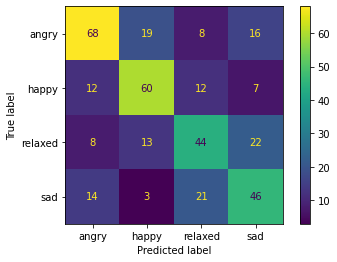

              precision    recall  f1-score   support

       angry       0.67      0.61      0.64       111
       happy       0.63      0.66      0.65        91
     relaxed       0.52      0.51      0.51        87
         sad       0.51      0.55      0.53        84

    accuracy                           0.58       373
   macro avg       0.58      0.58      0.58       373
weighted avg       0.59      0.58      0.59       373



In [189]:
decTreeModel.fit(train_data, target_train)
predictions = decTreeModel.predict(test_data)
print("Accuracy = " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(decTreeModel, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [190]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.5753426031878386

### Decision Tree (Gini Index)

In [191]:
decTreeModel2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=4, min_samples_split=10, random_state=0)
scores=cross_val_score(decTreeModel2, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.54666667 0.58       0.61744966 0.54362416 0.56375839 0.55033557
 0.51006711 0.62416107 0.61073826 0.55033557]
Accuracy: 0.5697 (+/- 0.07)


Gini Index:
Accuracy= 0.6005361930294906
Confusion Matrix:


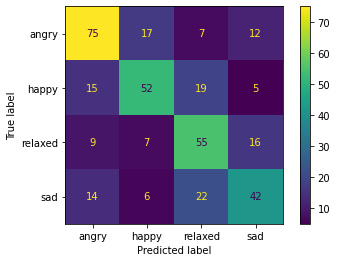

              precision    recall  f1-score   support

       angry       0.66      0.68      0.67       111
       happy       0.63      0.57      0.60        91
     relaxed       0.53      0.63      0.58        87
         sad       0.56      0.50      0.53        84

    accuracy                           0.60       373
   macro avg       0.60      0.59      0.59       373
weighted avg       0.60      0.60      0.60       373



In [192]:
decTreeModel2.fit(train_data, target_train)
predictions = decTreeModel2.predict(test_data)
print("Gini Index:")
print("Accuracy= " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(decTreeModel2, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [193]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.5872147337515013

### Random Forest (Gini index)

In [184]:
#rdfgi = RandomForestClassifier(random_state=0)
#rdfgi = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
rdfgi = RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=0)
scores=cross_val_score(rdfgi, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

Score by fold: [0.66       0.71333333 0.62416107 0.65771812 0.68456376 0.63087248
 0.59731544 0.65771812 0.70469799 0.63758389]
Accuracy: 0.6568 (+/- 0.03)


Accuracy= 0.6595174262734584
Confusion Matrix:


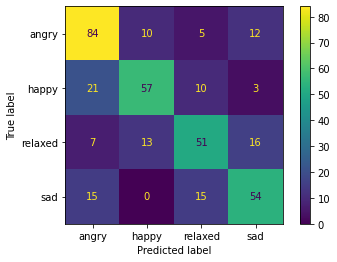

              precision    recall  f1-score   support

       angry       0.66      0.76      0.71       111
       happy       0.71      0.63      0.67        91
     relaxed       0.63      0.59      0.61        87
         sad       0.64      0.64      0.64        84

    accuracy                           0.66       373
   macro avg       0.66      0.65      0.65       373
weighted avg       0.66      0.66      0.66       373



In [185]:
rdfgi.fit(train_data, target_train)
predictions = rdfgi.predict(test_data)
print("Accuracy= " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(rdfgi, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [186]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6473164670212237

In [173]:
cols = np.array(['lyric sentiment - neg', 'lyric sentiment - pos', 'mode - major', 'mode - minor', 'danceability','energy', 'loudness','valence','tempo'])

<BarContainer object of 9 artists>

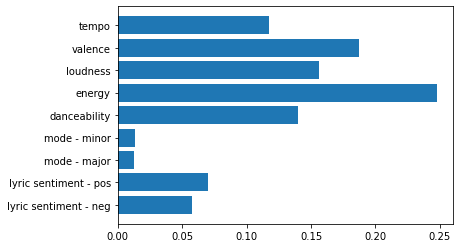

In [174]:
plt.barh(cols, rdfgi.feature_importances_)

### Random Forest (Entropy)

In [181]:
rdfen = RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=0)
scores=cross_val_score(rdfen, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

Score by fold: [0.65333333 0.72       0.65771812 0.65100671 0.67785235 0.60402685
 0.57718121 0.6442953  0.69798658 0.63087248]
Accuracy: 0.6514 (+/- 0.04)


Accuracy= 0.6541554959785523
Confusion Matrix:


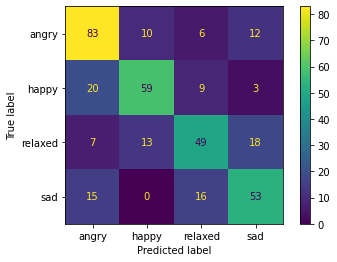

              precision    recall  f1-score   support

       angry       0.66      0.75      0.70       111
       happy       0.72      0.65      0.68        91
     relaxed       0.61      0.56      0.59        87
         sad       0.62      0.63      0.62        84

    accuracy                           0.65       373
   macro avg       0.65      0.65      0.65       373
weighted avg       0.65      0.65      0.65       373



In [182]:
rdfen.fit(train_data, target_train)
predictions = rdfen.predict(test_data)
print("Accuracy= " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(rdfen, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [183]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6410114500794006

<BarContainer object of 9 artists>

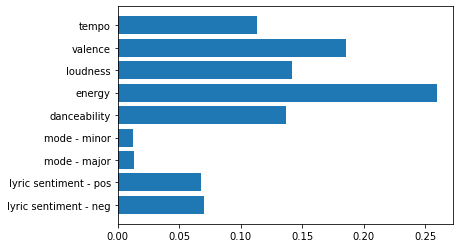

In [67]:
plt.barh(cols, rdfen.feature_importances_)

### Random Forest (RandomizedSearch)

In [105]:
rdf_randser = RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [106]:
scores=cross_val_score(rdf_randser, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

Score by fold: [0.66666667 0.71333333 0.66442953 0.65100671 0.69127517 0.62416107
 0.58389262 0.65100671 0.69798658 0.63758389]
Accuracy: 0.6581 (+/- 0.04)


Accuracy= 0.6541554959785523
Confusion Matrix:


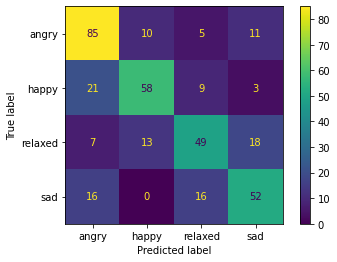

              precision    recall  f1-score   support

       angry       0.66      0.77      0.71       111
       happy       0.72      0.64      0.67        91
     relaxed       0.62      0.56      0.59        87
         sad       0.62      0.62      0.62        84

    accuracy                           0.65       373
   macro avg       0.65      0.65      0.65       373
weighted avg       0.65      0.65      0.65       373



In [110]:
rdf_randser.fit(train_data, target_train)
predictions = rdf_randser.predict(test_data)
print("Accuracy= " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(rdf_randser, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [111]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6383919988620218

### KNN

In [85]:
train_df = pd.DataFrame(data=instances_train[0:,0:], columns=headers)

In [86]:
test_df = pd.DataFrame(data=instances_test[0:,0:], columns=headers)

In [90]:
loud_scaler = preprocessing.MinMaxScaler()
tempo_scaler = preprocessing.MinMaxScaler()
loud_scaler.fit(np.array([-60.0,0.0])[:, np.newaxis])
train_df['tempo'] = tempo_scaler.fit_transform(np.array(train_df['tempo'])[:, np.newaxis])
train_df['loudness'] = loud_scaler.transform(np.array(train_df['loudness'])[:, np.newaxis])

In [100]:
train_df[['tempo','loudness']]

,tempo,loudness
0,0.480927,0.912300
1,0.468452,0.678033
2,0.509380,0.804917
3,0.459579,0.937117
4,0.336572,0.618783
...,...,...
1487,0.274966,0.894617
1488,0.432467,0.846650
1489,0.516856,0.830750
1490,0.391278,0.888050


In [97]:
test_df['tempo'] = tempo_scaler.transform(np.array(test_df['tempo'])[:, np.newaxis])
test_df['loudness'] = loud_scaler.transform(np.array(test_df['loudness'])[:, np.newaxis])

In [102]:
train_df[cont_features]

,danceability,energy,loudness,valence,tempo
0,0.522,0.889,0.912300,0.924,0.480927
1,0.545,0.154,0.678033,0.152,0.468452
2,0.658,0.317,0.804917,0.486,0.509380
3,0.568,0.906,0.937117,0.368,0.459579
4,0.64,0.153,0.618783,0.34,0.336572
...,...,...,...,...,...
1487,0.457,0.779,0.894617,0.734,0.274966
1488,0.684,0.677,0.846650,0.774,0.432467
1489,0.593,0.542,0.830750,0.564,0.516856
1490,0.221,0.967,0.888050,0.0395,0.391278


In [103]:
train_data = np.hstack((vec_categorical, train_df[cont_features].values))

In [105]:
test_data = np.hstack((test_vec_categorical, test_df[cont_features].values))

In [107]:
knn = KNeighborsClassifier(algorithm='brute', n_neighbors=22, weights='distance')

In [108]:
scores=cross_val_score(knn, train_data, target_train, cv=10)
print("Score by fold: " + str(scores))
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score by fold: [0.62       0.73333333 0.69798658 0.63758389 0.68456376 0.63758389
 0.62416107 0.63758389 0.69127517 0.65771812]
Accuracy: 0.6622 (+/- 0.07)


Accuracy= 0.6327077747989276
Confusion Matrix:


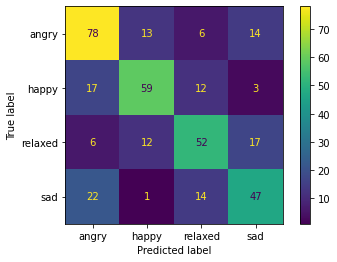

              precision    recall  f1-score   support

       angry       0.63      0.70      0.67       111
       happy       0.69      0.65      0.67        91
     relaxed       0.62      0.60      0.61        87
         sad       0.58      0.56      0.57        84

    accuracy                           0.63       373
   macro avg       0.63      0.63      0.63       373
weighted avg       0.63      0.63      0.63       373



In [109]:
knn.fit(train_data, target_train)
predictions = knn.predict(test_data)
print("Accuracy= " + str(accuracy_score(target_test, predictions, normalize=True)))
#Output the confusion matrix on the test set
print("Confusion Matrix:")
plot_confusion_matrix(knn, test_data, target_test)
plt.show()
print(classification_report(target_test, predictions))

In [110]:
cal_hm_acc(classification_report(target_test, predictions, output_dict=True))

0.6224943851995911

### RandomizedSearch

In [99]:
parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'criterion': ['gini', 'entropy']
}
              

In [100]:
rf = RandomForestClassifier(random_state=0)
rs_rf = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10, verbose=1)

In [101]:
rs_rf.fit(train_data, target_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.6min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]},
                   verbose=1)

In [102]:
for param in sorted(parameters.keys()):
    print("%s: %r" % (param, rs_rf.best_params_[param]))

bootstrap: True
criterion: 'entropy'
max_depth: None
max_features: 'sqrt'
min_samples_leaf: 4
min_samples_split: 5
n_estimators: 200


In [103]:
rs_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [104]:
rs_rf.best_score_

0.6601521252796421

### GridSearch

In [68]:
parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200],
    'criterion': ('gini', 'entropy')
             }

In [46]:
rf = RandomForestClassifier()

In [69]:
grid = GridSearchCV(rf, parameters, cv=10, n_jobs=1, verbose=1)

In [80]:
train_data[0]

array([  0.   ,   1.   ,   1.   ,   0.   ,   0.522,   0.889,  -5.262,
       123.736,   0.924])

In [70]:
grid.fit(train_data, target_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed: 41.6min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ('gini', 'entropy'),
                         'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)

In [71]:
for param in sorted(parameters.keys()):
    print("%s: %r" % (param, grid.best_params_[param]))

bootstrap: True
criterion: 'gini'
max_depth: 20
max_features: 'auto'
min_samples_leaf: 4
min_samples_split: 10
n_estimators: 200


In [72]:
grid.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200)

In [73]:
grid.best_score_

0.6681879194630873

### Single Instance from test

In [75]:
query = instances_test[7]
query_target = target_test[10]
#for feature, intervals in bin_intervals.items():
#    for interval in intervals:
#        if querie[feature] < interval.right:
#            querie[feature] = interval
#            break
query_prediction = knn.predict([query])
print("Prediction:", query_prediction, "Actual:", query_target)

Prediction: ['relaxed'] Actual: sad


### Unseen data

In [ ]:
# New instance as dict
# Dict to dataframe
# Put categorical feature in new df
# Put continuous feature in new df
# Convert continues features to categorical using bins
# Prepare data for classification